In [1]:
from typing import Dict, List, Optional, Tuple
from typing_extensions import Text
import tensorflow as tf
import re
import sys
sys.path.append('/home/kosta/Fire-Mask-Prediction')
from data_utils import *
from data_utils.data_cons import INPUT_FEATURES, OUTPUT_FEATURES, TITLES
from data_utils.parse_files import get_dataset
from data_utils.augs import random_crop_input_and_output_images
import matplotlib.pyplot as plt
from matplotlib import colors
def split_inputs(inputs, labels):
    # Split inputs into features and mask
    features = inputs[..., :-1]  # All channels except the last
    mask = inputs[..., -1:]      # The last channel, keeping dimensions
    return (features, mask), labels




2024-11-20 18:16:07.380440: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 18:16:07.387265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732151767.395984   45188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732151767.398744   45188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 18:16:07.407116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load the dataset
dataset = get_dataset(
    '/mnt/c/Users/kosta/Downloads/archive (1)/next_day_wildfire_spread_test*',
    data_size=64,
    sample_size=64,
    batch_size=32,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=True,
    clip_and_rescale=False,
    random_crop=True,
    center_crop=False
)

# Apply the split_inputs function to your dataset
dataset = dataset.map(split_inputs)


I0000 00:00:1732151768.750269   45188 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


In [3]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.

    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES

    # Get the first batch from the dataset
    for elem in dataset.take(1):
        #print the data type of the element
        print(type(elem))
        (features, mask), labels = elem
        print(type(features))
        print(type(mask))
        break  # Only take the first batch

    # Check the shapes
    print("Shape of features:", features.shape)  # Expected: (batch_size, height, width, num_features)
    print("Shape of mask:", mask.shape)          # Expected: (batch_size, height, width, 1)
    print("Shape of labels:", labels.shape)      # Expected: (batch_size, height, width, num_label_channels)

    # Ensure that the number of channels in labels is as expected
    num_label_channels = labels.shape[-1]
    print(f"Number of channels in each label: {num_label_channels}")

    # Plotting
    fig = plt.figure(figsize=(15, 6.5))

    # Define the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    # Number of feature variables
    n_features = features.shape[-1]

    for i in range(n_rows):
        for j in range(n_features + 2):  # +2 for mask and label
            plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)
            
            # Set titles for the first row
            if i == 0:
                if j < n_features:
                    plt.title(TITLES[j], fontsize=13)
                elif j == n_features:
                    plt.title("Mask", fontsize=13)
                else:
                    plt.title("Label", fontsize=13)
            
            # Plot features
            if j < n_features:
                plt.imshow(features[i, :, :, j], cmap='viridis')
            # Plot mask
            elif j == n_features:
                plt.imshow(mask[i, :, :, 0], cmap=CMAP, norm=NORM)
            # Plot label
            else:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
            
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


2024-11-20 18:16:09.442316: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-11-20 18:16:09.442363: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


<class 'tuple'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
Shape of features: (32, 64, 64, 11)
Shape of mask: (32, 64, 64, 1)
Shape of labels: (32, 64, 64, 1)
Number of channels in each label: 1


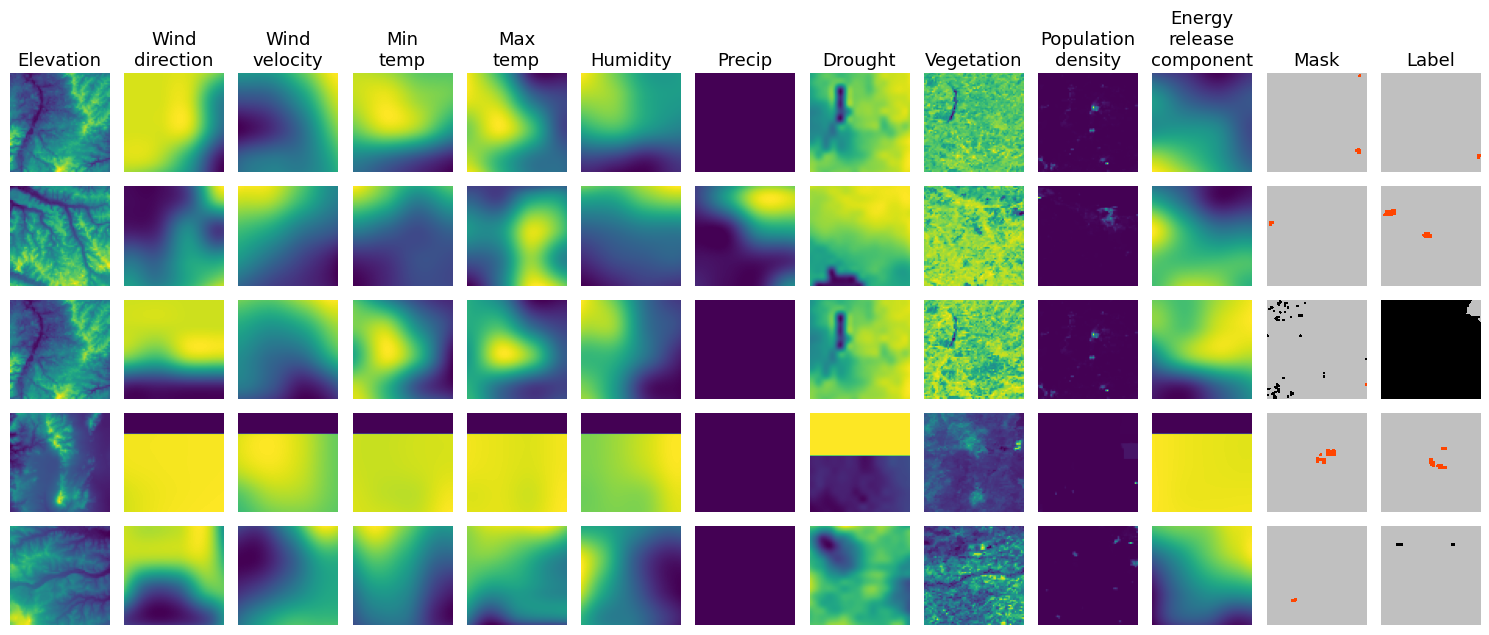

In [4]:
plot_samples_from_dataset(dataset, n_rows=5)


In [5]:
import torch
from torch.utils.data import Dataset

class TFToTorchDataset(Dataset):
    def __init__(self, tf_dataset):
        
        self.tf_dataset = list(tf_dataset.unbatch().as_numpy_iterator())  # Convert to NumPy-compatible list

    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        # Get the data
        data = self.tf_dataset[idx]
        
        # Try unpacking (features, mask), labels
        try:
            (features, mask), labels = data
        except ValueError as e:
            print(f"Error unpacking data at index {idx}: {e}")
            print("Data:", data)
            raise

        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return (features, mask), labels




In [6]:
# Remove batching from the TensorFlow dataset


pytorch_dataset = TFToTorchDataset(dataset)

from torch.utils.data import DataLoader
dataloader = DataLoader(pytorch_dataset, batch_size=32, shuffle=True)


2024-11-20 18:16:12.873254: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
dataloader = DataLoader(pytorch_dataset, batch_size=32, shuffle=True)

for batch_idx, ((features, mask), labels) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print(f"  Features shape: {features.shape}")
    print(f"  Mask shape: {mask.shape}")
    print(f"  Labels shape: {labels.shape}")
    break


Batch 1
  Features shape: torch.Size([32, 64, 64, 11])
  Mask shape: torch.Size([32, 64, 64, 1])
  Labels shape: torch.Size([32, 64, 64, 1])


In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

def plot_samples_from_pytorch_dataloader(dataloader, n_rows: int):
    """
    Plot 'n_rows' rows of samples from a PyTorch DataLoader.

    Args:
        dataloader: PyTorch DataLoader object.
        n_rows (int): Number of rows to plot.
    """
    global TITLES

    # Get a batch from the DataLoader
    for ((features, mask), labels) in dataloader:
        break  # Take only the first batch

    # Convert tensors to numpy for plotting
    features = features.numpy()
    mask = mask.numpy()
    labels = labels.numpy()

    # Check the shapes
    print("Shape of features:", features.shape)  # Expected: (batch_size, height, width, num_features)
    print("Shape of mask:", mask.shape)          # Expected: (batch_size, height, width, 1)
    print("Shape of labels:", labels.shape)      # Expected: (batch_size, height, width, 1)

    # Define the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    # Number of feature variables
    n_features = features.shape[-1]

    fig = plt.figure(figsize=(15, 6.5))
    for i in range(n_rows):
        for j in range(n_features + 2):  # +2 for mask and label
            plt.subplot(n_rows, n_features + 2, i * (n_features + 2) + j + 1)

            # Set titles for the first row
            if i == 0:
                if j < n_features:
                    plt.title(TITLES[j], fontsize=13)
                elif j == n_features:
                    plt.title("Mask", fontsize=13)
                else:
                    plt.title("Label", fontsize=13)

            # Plot features
            if j < n_features:
                plt.imshow(features[i, :, :, j], cmap='viridis')
            # Plot mask
            elif j == n_features:
                plt.imshow(mask[i, :, :, 0], cmap=CMAP, norm=NORM)
            # Plot label
            else:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)

            plt.axis('off')

    plt.tight_layout()
    plt.show()


Shape of features: (32, 64, 64, 11)
Shape of mask: (32, 64, 64, 1)
Shape of labels: (32, 64, 64, 1)


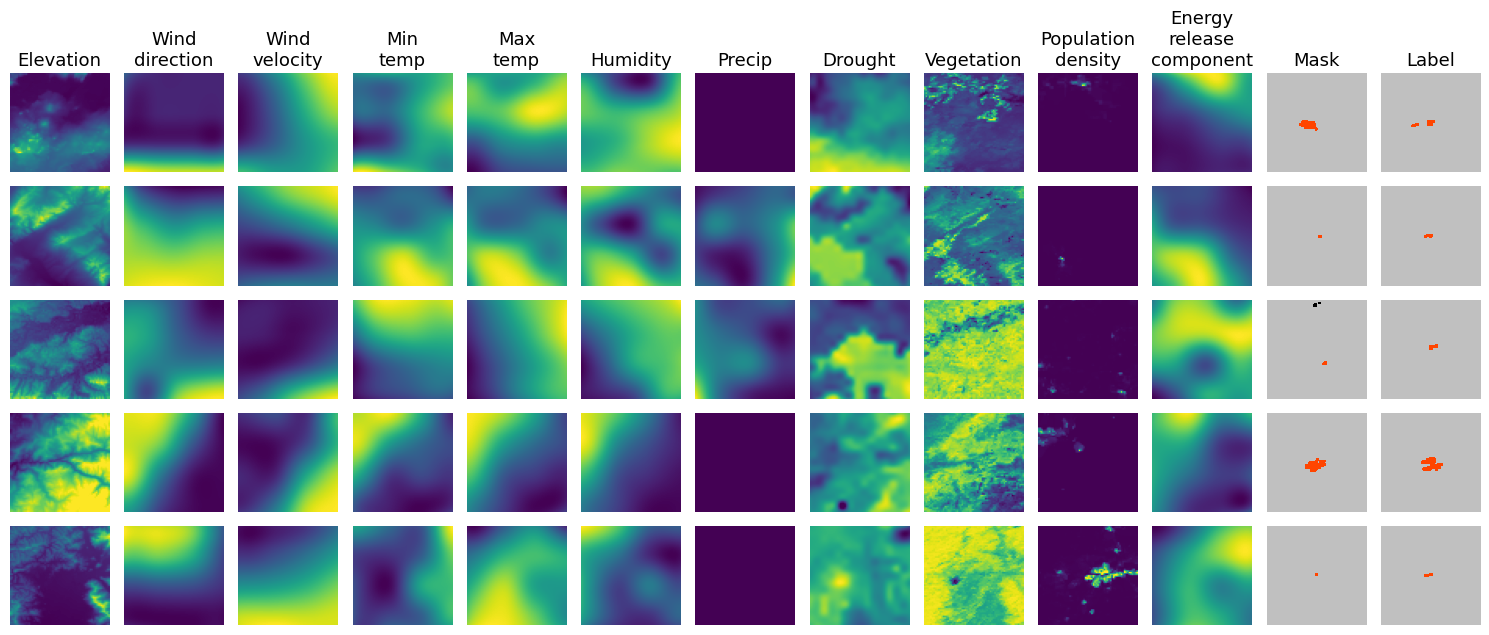

In [9]:
plot_samples_from_pytorch_dataloader(dataloader, n_rows=5)
